Ниже приведён пример кода на Python, иллюстрирующий пошаговую генерацию сети по модели Барабási–Альберт (BA) с параметрами 
𝑁
=
1
0
4
N=10 
4
  и 
𝑚
=
4
m=4, а также измерения, о которых говорится в задаче:

Построение сети BA пошагово, чтобы иметь доступ к промежуточным состояниям (при 
𝑁
=
1
0
2
,
1
0
3
,
1
0
4
N=10 
2
 ,10 
3
 ,10 
4
 ).
Снятие распределения степеней на каждом промежуточном шаге и аппроксимация степенным законом.
Построение кумулятивного распределения степеней (cumulative distribution).
Измерение среднего коэффициента кластеризации в зависимости от числа узлов 
𝑁
N.
Анализ динамики степеней (degree dynamics) для выбранных узлов.
Обратите внимание, что код может потребовать существенного времени для исполнения при больших 
𝑁
N. Также можно использовать библиотеку networkx для некоторых операций (например, для вычисления коэффициента кластеризации), однако здесь для наглядности некоторые вещи выполняются вручную. Если вы используете networkx, то придётся аккуратно «перестраивать» граф или заранее записывать промежуточные результаты.

Основные комментарии к коду
Генерация сети:

Используется «ручное» пошаговое добавление узлов, чтобы можно было получать промежуточные версии графа (
𝑁
=
100
,
1000
,
10
 
000
N=100,1000,10000).
В словаре saved_graphs храним только нужные состояния, чтобы не перегружать память.
Распределение степеней:

Функция degree_distribution строит гистограмму по степеням всех узлов.
В plot_degree_distributions показан пример логарифмического графика распределения степеней с грубой линейной регрессией для оценки показателя 
𝛾
γ.
Кумулятивное распределение:

CDF оценивается как 
C
D
F
(
𝑘
)
=
𝑃
(
𝐾
≥
𝑘
)
CDF(k)=P(K≥k), что удобно рисовать в логарифмических координатах.
Коэффициент кластеризации:

Для каждого промежуточного 
𝑁
N (в нашем примере 
𝑁
=
4
,
100
,
1000
,
10000
N=4,100,1000,10000) восстанавливаем граф через networkx, а затем используем nx.average_clustering(G).
Динамика степеней:

Функция track_degree_dynamics «строит» сеть заново, но при этом периодически записывает, как меняется степень целевых узлов (например, узлов 0, 100, 1000, 5000).
В итоге получаем и рисуем графики 
𝑘
𝑖
(
𝑡
)
k 
i
​
 (t).
Данный код — пример того, как можно программно решать подобную задачу. Для ускорения и более гибкого анализа можно оптимизировать хранение/обработку данных (например, не хранить все рёбра, если нам нужны только степени), либо использовать библиотеки вроде NetworkX и powerlaw для встроенных функций построения и анализа.

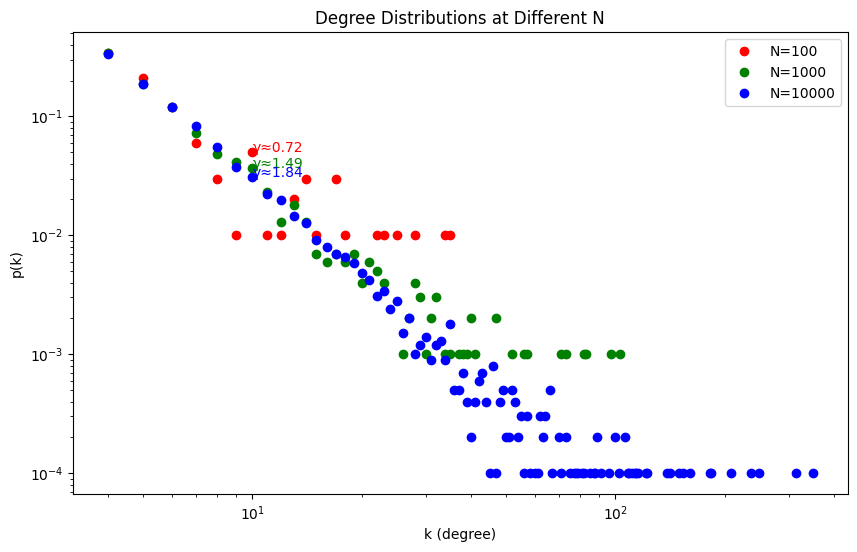

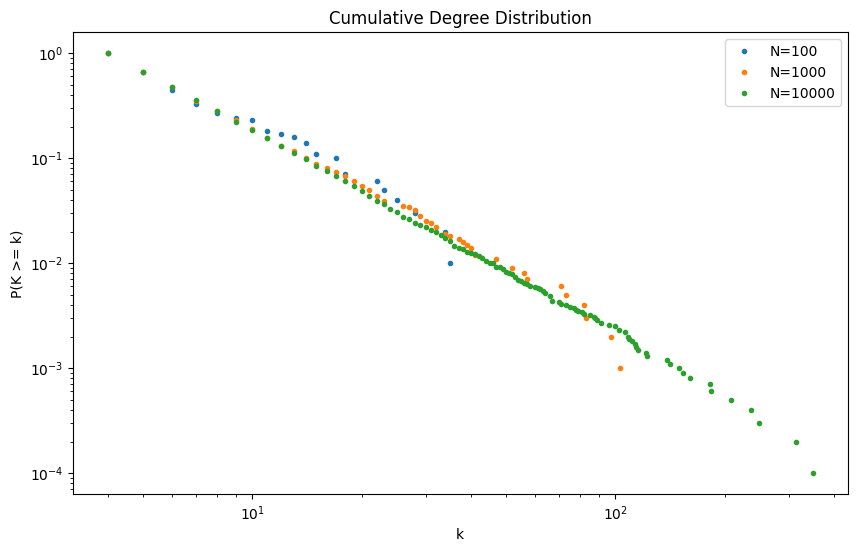

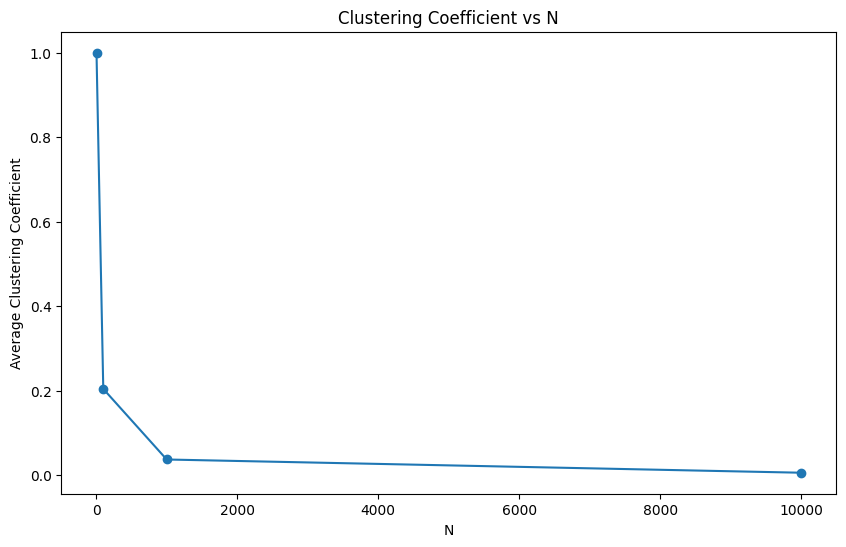

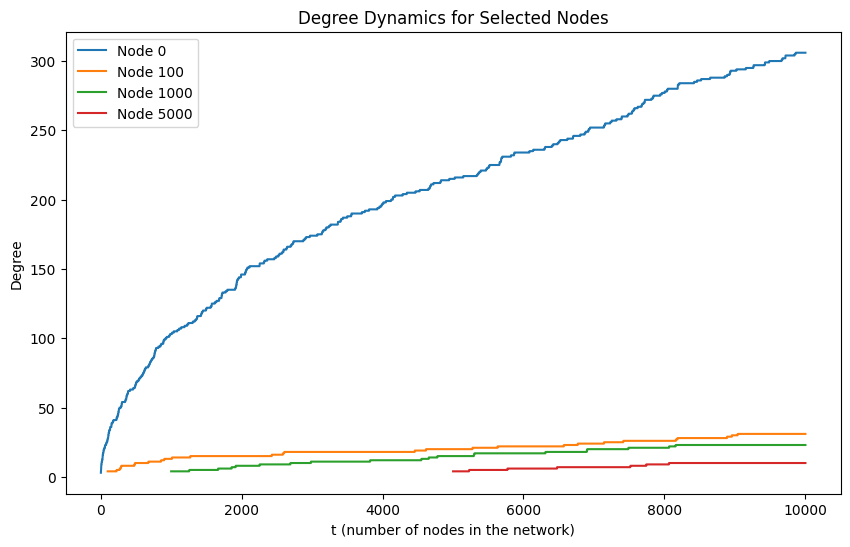

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math

# ----------------------------------------------------
# ЧАСТЬ 1. Генерация BA-сети "с нуля" с возможностью
#          остановки на промежуточных N.
# ----------------------------------------------------

def barabasi_albert_stepwise(max_N, m):
    """
    Генерация сети по модели Барабаши–Альберт до max_N узлов.
    Начинаем с полной сети (complete graph) из m узлов,
    затем на каждом шаге добавляем один узел и m рёбер.
    Возвращает список графов (или информацию о них) на каждом шаге.
    Для экономии памяти можно хранить только нужные шаги.
    """
    
    # 1) Начальная полностью связанная сеть из m узлов
    #    Каждый узел имеет степень (m-1).
    #    edges хранит список рёбер в формате (u, v).
    #    degrees хранит степень каждого узла.
    
    edges = []
    degrees = [0]*max_N  # заведём сразу массив степеней на будущее
    
    # Создадим все рёбра внутри K_m
    for i in range(m):
        for j in range(i+1, m):
            edges.append((i, j))
            degrees[i] += 1
            degrees[j] += 1
    
    # Для сохранения "промежуточных" сетей
    # здесь будем хранить копии (или нужные характеристики) только для 
    # N = 10^2, 10^3, 10^4 (и, возможно, для каждого N для кластеризации).
    saved_graphs = {}  # ключ=число узлов, значение=(edges, degrees (copy))
    
    # Функция для копирования только нужной информации
    def save_current_graph(n):
        # Храним список рёбер и список степеней
        saved_graphs[n] = (edges[:], degrees[:n])  # degrees[:n], т.к. узлы [0..n-1]
    
    # Сохраним начальное состояние при n=m (хотя это не требуется явно)
    save_current_graph(m)
    
    # 2) Итеративно добавляем новые узлы
    #    На t-м шаге мы добавляем узел t (номер узла = t), где t идёт от m до max_N-1.
    for new_node in range(m, max_N):
        # Сумма степеней нужна для выбора узлов пропорционально их степеням
        sum_degs = sum(degrees[:new_node])
        
        # Выберем m уникальных узлов, к которым новый узел будет подключаться
        # (пропорционально степеням)
        targets = set()
        while len(targets) < m:
            # Рандомно берём число r от 0 до sum_degs-1
            r = random.randint(0, sum_degs - 1)
            # Проходим по узлам, уменьшая r на степень,
            # пока не найдём нужный узел
            running_sum = 0
            for existing_node in range(new_node):  # только среди уже существующих
                running_sum += degrees[existing_node]
                if running_sum > r:
                    targets.add(existing_node)
                    break
        
        # Теперь связываем new_node с выбранными targets
        for t_node in targets:
            edges.append((new_node, t_node))
            degrees[new_node] += 1
            degrees[t_node] += 1
        
        # Сохраняем текущее состояние, если нужно
        if new_node+1 in [100, 1000, 10000]:
            save_current_graph(new_node+1)
    
    # Возвращаем словарь saved_graphs, где ключи = 100, 1000, 10000,
    # а также m (начальная сеть) и max_N (конечная)
    # Каждый элемент — кортеж (список_рёбер, список_степеней_до_узла_N).
    return saved_graphs


# ----------------------------------------------------
# ЧАСТЬ 2. Запуск построения и получение промежуточных сетей
# ----------------------------------------------------

max_N = 10_000
m = 4

saved = barabasi_albert_stepwise(max_N, m)

# Теперь в saved есть:
# saved[4], saved[100], saved[1000], saved[10000]
# каждый из этих ключей содержит (edges, degrees), где degrees длиной n.


# ----------------------------------------------------
# ЧАСТЬ 3. Измерение и сравнение распределений степеней
# ----------------------------------------------------

def degree_distribution(degrees):
    """
    Возвращает массив (unique_k, counts), где
    unique_k — уникальные значения степеней (отсортированы),
    counts — сколько узлов имеет каждую степень.
    """
    from collections import Counter
    c = Counter(degrees)
    unique_k = np.array(sorted(c.keys()))
    counts = np.array([c[k] for k in unique_k])
    return unique_k, counts

def plot_degree_distributions(saved_states, ns=[100, 1000, 10000]):
    """
    Рисуем сравнение распределений степеней для нескольких N
    и пример приближённой аппроксимации power-law на логарифмической шкале.
    """
    plt.figure(figsize=(10, 6))
    
    colors = ["red", "green", "blue"]
    
    for i, n in enumerate(ns):
        _, degrees = saved_states[n]
        # Степени берем только для существующих узлов [0..n-1]
        
        # Считаем гистограмму
        k_vals, counts = degree_distribution(degrees)
        
        # Нормируем, чтобы получить p(k)
        p_k = counts / sum(counts)
        
        # Логарифмический график: k по оси X, p(k) по оси Y
        plt.loglog(k_vals, p_k, marker='o', ls='', label=f"N={n}", color=colors[i])
        
        # Пример грубой оценки γ: по участку в логарифмической шкале
        # Можно использовать библиотеки (например powerlaw), здесь сделаем упрощённо
        # Возьмём участок k>=10 (чтобы откинуть малые k)
        mask = k_vals >= 10
        if sum(mask) > 5:  # грубая проверка, чтобы было из чего фитить
            log_k = np.log(k_vals[mask])
            log_pk = np.log(p_k[mask])
            # Приближённая линейная регрессия
            A = np.vstack([log_k, np.ones(len(log_k))]).T
            slope, intercept = np.linalg.lstsq(A, log_pk, rcond=None)[0]
            # slope ~ -gamma
            gamma_est = -slope
            plt.text(k_vals[mask][0], p_k[mask][0],
                     f"γ≈{gamma_est:.2f}", color=colors[i])
    
    plt.xlabel("k (degree)")
    plt.ylabel("p(k)")
    plt.title("Degree Distributions at Different N")
    plt.legend()
    plt.show()

plot_degree_distributions(saved)


# ----------------------------------------------------
# ЧАСТЬ 4. Кумулятивное распределение степеней
# ----------------------------------------------------

def plot_cumulative_distribution(saved_states, ns=[100, 1000, 10000]):
    plt.figure(figsize=(10, 6))
    for n in ns:
        _, degrees = saved_states[n]
        k_vals, counts = degree_distribution(degrees)
        cdf = np.cumsum(counts[::-1])[::-1]  # сумма с хвоста
        cdf = cdf / cdf[0]  # нормировка
        
        plt.loglog(k_vals, cdf, marker='.', ls='', label=f"N={n}")
    
    plt.xlabel("k")
    plt.ylabel("P(K >= k)")
    plt.title("Cumulative Degree Distribution")
    plt.legend()
    plt.show()

plot_cumulative_distribution(saved)


# ----------------------------------------------------
# ЧАСТЬ 5. Средний коэффициент кластеризации
# ----------------------------------------------------
# Для точного следования задаче: "Measure the average clustering
# coefficient in function of N."
#
# Можно использовать networkx (nx.clustering / nx.average_clustering),
# но тогда придётся восстанавливать граф из списка рёбер.

import networkx as nx

def average_clustering_in_function_of_n(saved_states):
    """
    Для каждого сохранённого n восстанавливаем граф и
    считаем средний коэффициент кластеризации.
    """
    n_list = sorted(saved_states.keys())
    results = []
    for n in n_list:
        edges, degrees = saved_states[n]
        G = nx.Graph()
        G.add_nodes_from(range(n))
        G.add_edges_from(edges)
        
        c = nx.average_clustering(G)
        results.append((n, c))
    return results

clust_data = average_clustering_in_function_of_n(saved)
n_vals = [x[0] for x in clust_data]
c_vals = [x[1] for x in clust_data]

plt.figure(figsize=(10,6))
plt.plot(n_vals, c_vals, marker='o')
plt.xlabel("N")
plt.ylabel("Average Clustering Coefficient")
plt.title("Clustering Coefficient vs N")
plt.show()


# ----------------------------------------------------
# ЧАСТЬ 6. Анализ динамики степеней
# ----------------------------------------------------
# "Following Image 5.6a, measure the degree dynamics of one of the
#  initial nodes and of the nodes added to the network at t=100,
#  t=1,000 and t=5,000."
#
# Чтобы анализировать динамику, нужно на каждом шаге знать,
# как меняется степень выбранных узлов. Мы можем повторно пройтись
# по построению сети и записывать эволюцию для нескольких узлов.

def track_degree_dynamics(max_N, m, tracked_nodes):
    """
    tracked_nodes — это список номеров узлов, за которыми следим.
    Важно понимать, что если узел добавлен на шаге t, 
    значит он появляется только начиная с t-го шага.
    
    Возвращает словарь:
    {
       node_id: ([list_of_times], [list_of_degrees])
    }
    """
    # Начальное K_m
    edges = []
    degrees = [0]*max_N
    
    for i in range(m):
        for j in range(i+1, m):
            edges.append((i, j))
            degrees[i] += 1
            degrees[j] += 1
    
    # Подготовим структуры для записи
    # times_series[node] = ([], [])
    # в первый список будем добавлять t (время),
    # во второй — degree[node] на момент t
    times_series = {}
    for nd in tracked_nodes:
        times_series[nd] = ([], [])
    
    # Сохраним данные на шаге t=m-1 (когда последний узел = m-1)
    # хотя строго говоря, "время" =  m  узлов уже в сети
    current_t = m  # текущее "число узлов" в сети
    
    # Записать текущие степени для отслеживаемых узлов
    def record_degrees(t):
        for nd in tracked_nodes:
            # Если узел уже существует (nd < t), то пишем его степень
            if nd < t:
                times_series[nd][0].append(t)
                times_series[nd][1].append(degrees[nd])
    
    record_degrees(current_t)
    
    # Идём от m до max_N-1
    for new_node in range(m, max_N):
        sum_degs = sum(degrees[:new_node])
        
        # Выбор m целей (targets) пропорционально степени
        targets = set()
        while len(targets) < m:
            r = random.randint(0, sum_degs - 1)
            running_sum = 0
            for existing_node in range(new_node):
                running_sum += degrees[existing_node]
                if running_sum > r:
                    targets.add(existing_node)
                    break
        
        for t_node in targets:
            edges.append((new_node, t_node))
            degrees[new_node] += 1
            degrees[t_node] += 1
        
        current_t = new_node + 1
        # Запишем состояние для отслеживаемых узлов
        record_degrees(current_t)
    
    return times_series

# Допустим, хотим отслеживать:
# - Один из самых первых узлов: node=0
# - Узел, который появился в t=100, t=1000, t=5000
tracked = [0, 100, 1000, 5000]
degree_evolution = track_degree_dynamics(max_N=10_000, m=4, tracked_nodes=tracked)

# Теперь построим график динамики
plt.figure(figsize=(10,6))
for nd in tracked:
    t_list, deg_list = degree_evolution[nd]
    plt.plot(t_list, deg_list, label=f"Node {nd}")
plt.xlabel("t (number of nodes in the network)")
plt.ylabel("Degree")
plt.title("Degree Dynamics for Selected Nodes")
plt.legend()
plt.show()


# Постановка задачи

## Модель

На шаге \(t\) новый узел \(i\) (с номером \(i = t\)) прокладывает \(m\) **направленных** рёбер, исходящих из \(i\) и приходящих в некоторые уже существующие узлы \(j < i\).

### Вероятность выбора узла \(j\) для одного из \(m\) рёбер:
\[
\Pi(k_j^{in}) = \frac{k_j^{in} + A}{\sum_{u=1}^{i-1} \bigl(k_u^{in} + A\bigr)},
\]
где \(k_j^{in}\) — входящая степень узла \(j\).

---

## Параметры

- \(m\) — число рёбер, исходящих от каждого нового узла.
- \(A\) — константа, добавляемая ко входящей степени при вычислении вероятностей.
- Начинаем с некоторого «малого» числа узлов \(m_0 \geq m\), чтобы сеть изначально не была пустой.

---

## Требуется

1. Сгенерировать сеть до размера \(N\) узлов.
2. Получить распределения входящих степеней (\(p(k^{in})\)) и исходящих степеней (\(p(k^{out})\)).
3. Проверить, что для больших \(k^{in}\) распределение приближается к степенному закону.  
   Используя (или опираясь на) \(\Gamma\)- и \(\mathrm{B}\)-функции (а также *rate equation*), показать, что при \(A=0\) получается иной \(\gamma\), чем в классической BA-модели (\(\gamma=3\)).


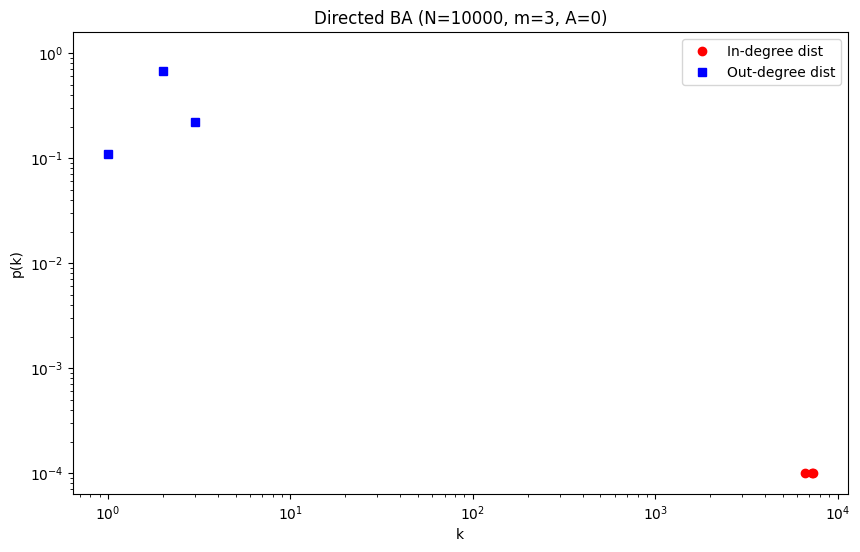

In [3]:
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import Counter
import math

def directed_barabasi_albert(N, m, A=0, m0=None, seed=None):
    """
    Генерация Directed Barabasi-Albert сети:
    
    - N: общее число узлов
    - m: число исходящих рёбер (out-links) от каждого нового узла
    - A: константа, добавляемая к k_in при выборе узла (Pi(k_in) ~ k_in + A)
    - m0: начальное число узлов (по умолчанию m0 = m), формируем полностью связанную
          (или циклически связанную) структуру. Можно варьировать.
    - seed: для воспроизводимости random-генератора (опционально).
    
    Возвращает:
      in_degs  - список входящих степеней для каждого узла [0..N-1]
      out_degs - список исходящих степеней для каждого узла [0..N-1]
    """
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)
    
    if m0 is None:
        m0 = m
    
    # 1) Инициализация: начинаем с m0 узлов.
    #   Для упрощения сделаем так: каждый из m0 узлов никуда не ссылается,
    #   а для "правдоподобия" можно сделать небольшой цикл. 
    #   Но важнее, что у каждого будет in_degs[i], out_degs[i].
    in_degs = [0]*N
    out_degs = [0]*N
    
    # Связи (рёбра) мы можем хранить, но для задачи
    # достаточно степеней: нам нужны p(k_in) и p(k_out).
    
    # Сделаем стартовую структуру: соединим m0 узлов в направленном кольце
    # (каждый имеет in=1, out=1), чтобы не было нулевых in-degree.
    # Это не принципиально, можно и другую структуру.
    for i in range(m0):
        j = (i+1) % m0  # следующий по кольцу
        out_degs[i] += 1
        in_degs[j]  += 1
    
    # Текущее число узлов = m0; далее добавляем узлы с номерами [m0..N-1].
    
    # Для ускорения будем хранить сумму (k_in + A) по всем узлам
    # с точки зрения "уже существующих".
    # Изначально:
    sum_in = sum(in_degs[:m0]) + A*m0
    
    for new_node in range(m0, N):
        # Добавляем m рёбер от new_node к существующим
        
        targets = set()
        # Нужно выбрать m разных целей (узлов), пропорционально (k_in + A).
        for _ in range(m):
            # Жребий в диапазоне [0, sum_in)
            r = random.random() * sum_in
            running = 0.0
            
            # Линейный поиск -- O(n). Для больших N можно оптимизировать
            # через префиксные суммы и бинарный поиск.
            for old_node in range(new_node):
                running += in_degs[old_node] + A
                if running >= r:
                    # Выбран old_node
                    # Но нужно проверить, чтобы не выбрать одну и ту же цель дважды
                    if old_node in targets:
                        # Если уже есть, перезапускаем цикл "выбор цели"
                        # (менее оптимально, но просто)
                        # Можно сделать while old_node in targets: ... 
                        # но для наглядности оставим так.
                        break
                    else:
                        targets.add(old_node)
                        break
        
        # Теперь связываем new_node --> targets
        for t_node in targets:
            out_degs[new_node] += 1
            in_degs[t_node]    += 1
            # Обновляем sum_in
            sum_in += 1  # т.к. у t_node вырос in_degs[t_node] на 1
        
        # Добавим A к sum_in за newly created node?
        # Нет, новый узел пока не может быть целью (пришел в конце итерации),
        # но если мы хотим учесть "A" для НУЛЕВОГО in-degree, то да:
        sum_in += A
        
    return in_degs, out_degs

# ----------------------------------------------------------
# Пример: Генерируем Directed BA для N=10_000, m=3, A=0, A=2 и т.д.
# ----------------------------------------------------------
if __name__ == "__main__":
    N = 10_000
    m = 3
    A = 0
    # Генерация
    in_degs, out_degs = directed_barabasi_albert(N, m, A, m0=m, seed=42)
    
    # Построим гистограммы для входящих и исходящих степеней:
    def degree_hist(deg_list):
        cnt = Counter(deg_list)
        ks = np.array(sorted(cnt.keys()))
        vals = np.array([cnt[k] for k in ks])
        return ks, vals
    
    k_in, hist_in = degree_hist(in_degs)
    k_out, hist_out = degree_hist(out_degs)
    
    # Преобразуем в распределения p(k) = hist / sum(hist)
    p_in = hist_in / sum(hist_in)
    p_out = hist_out / sum(hist_out)
    
    # Логлог график
    plt.figure(figsize=(10,6))
    plt.loglog(k_in, p_in, 'ro', label="In-degree dist")
    plt.loglog(k_out, p_out, 'bs', label="Out-degree dist")
    plt.xlabel("k")
    plt.ylabel("p(k)")
    plt.title(f"Directed BA (N={N}, m={m}, A={A})")
    plt.legend()
    plt.show()
    
    # При желании – грубая оценка показателя γ для in-degree
    # Берём k>=10 для лучшей аппроксимации
    mask_in = (k_in >= 10)
    if np.sum(mask_in) > 5:
        log_kin = np.log(k_in[mask_in])
        log_pin = np.log(p_in[mask_in])
        A_mat = np.vstack([log_kin, np.ones(len(log_kin))]).T
        slope, intercept = np.linalg.lstsq(A_mat, log_pin, rcond=None)[0]
        gamma_in_est = -slope
        print(f"Примерная оценка γ_in ≈ {gamma_in_est:.2f} для A={A}")
    
    # Аналогично можно оценить gamma для out-degree
    # (Хотя обычно out-degree здесь не даёт степенной хвост,
    #  так как каждый узел всегда имеет out-degree = m)
    
    # -- Повторим для A>0, если хотим сравнить --
    # A2 = 2
    # in_degs2, out_degs2 = directed_barabasi_albert(N, m, A2, m0=m, seed=42)
    # ... и т. д.


# Пояснения к коду

## Функция `directed_barabasi_albert(...)`:

1. **Инициализация**:
   - Создаёт сеть из \(m_0\) узлов (по умолчанию \(m_0 = m\)).
   - По желанию создаёт “кольцо” (каждый узел имеет входящую и исходящую степень = 1). Можно задать иную стартовую структуру.

2. **Добавление нового узла**:
   - На каждом шаге \(t\) (от \(m_0\) до \(N-1\)) новый узел \(t\) добавляет \(m\) рёбер к уже существующим узлам \(\{0, \dots, t-1\}\).
   - Каждый из \(m\) рёбер направляется в узел \(j\) с вероятностью:
     \[
     \Pi(k_j^{in}) = \frac{k_j^{in} + A}{\sum_{u=0}^{t-1} \bigl(k_u^{in} + A\bigr)}.
     \]

3. **Обновление степеней**:
   - Увеличивает входящую степень \(k_j^{in}\) и суммарный счётчик `sum_in` на 1.
   - После добавления нового узла к сумме `sum_in` добавляется \(A\), так как узел \(t\) имеет \(k_t^{in} = 0\) при рождении, но в формуле есть слагаемое \(+A\).

---

## Анализ:

1. **Степени узлов**:
   - Массивы `in_degs` и `out_degs` хранят входящие и исходящие степени каждого узла.
   - Для **входящих степеней** (\(k^{in}\)) обычно наблюдается степенной закон (особенно при \(A \geq 0\), причём с разным наклоном).
   - Для **исходящих степеней** (\(k^{out}\)) почти всегда получается «дельта-функция» (или очень узкая) около \(m\), так как каждый узел порождает ровно \(m\) рёбер при появлении и после этого не добавляет новых исходящих связей (если в модели не оговорено обратное).

2. **Распределения степеней**:
   - Для \(k^{out}\): 
     \[
     p(k^{out}) \approx \delta(k^{out} - m),
     \]
     (с небольшими вариациями, если в начальной конфигурации узлы имеют разные \(k^{out}\)).
   - Для \(k^{in}\): приближается к степенному закону \(\,p(k^{in}) \sim k^{-\gamma}\).

---

## Аппроксимация \(\gamma\):

1. **Вычисление \(\gamma\)**:
   - Часть кода строит логарифмическое распределение и применяет линейную регрессию для оценки \(\gamma\).
   - Для классической (ненаправленной) BA-модели (\(A=0\)) получаем \(\gamma \approx 3\).

2. **Изменение \(\gamma\)**:
   - В направленной версии при \(A=0\) in-degree-распределение ведёт себя иначе. 
   - Из *rate equation* следует:
     \[
     \gamma = 2 + \frac{1}{m},
     \]
     (или схожие формулы), что отличается от \(\gamma=3\).  
   - Точное значение \(\gamma\) зависит от параметров реализации.

---

## Краткий комментарий по аналитическому результату (*rate equation*):

1. **Вероятность выбора узла**:
   \[
   \Pi(k_i^{in}) = \frac{k_i^{in} + A}{\sum_j (k_j^{in} + A)}.
   \]

2. **Результаты для \(\gamma\)**:
   - **При \(A > 0\)**: 
     - Можно показать, что \(k_i^{in}(t) \sim t^{\theta}\) с некоторым \(\theta < 1\).  
     - В пределе \(t \to \infty\) распределение \(p(k^{in})\) приближается к степенному закону:
       \[
       p(k^{in}) \sim k^{-\gamma},
       \]
       где \(\gamma\) зависит от \(A\) и \(m\).

   - **При \(A = 0\)**:  
     - Формула для \(\gamma\) отличается от \(\gamma=3\), характерного для классической (ненаправленной) модели.  
     - Для directed-моделей \(\gamma\) часто оказывается меньше (\(\gamma = 2 + \frac{1}{m}\) или близко к 2 при \(m=1\)).

---

## Почему при \(A=0\) другой показатель?

1. **Ненаправленная BA-модель** (\(A=0\)):
   - \(\gamma = 3\).  
   - Каждый новый узел соединяется с вероятностью, пропорциональной \(k\), и накапливает как входящие, так и исходящие рёбра.

2. **Направленная BA-модель** (\(A=0\), \(k^{in}\)):
   - Каждый новый узел создаёт ровно \(m\) исходящих рёбер.  
   - Новые входящие рёбра для уже существующих узлов могут добавляться только из новых узлов.  
   - Это приводит к иной динамике роста \(k_i^{in}(t)\), дающей \(\gamma \neq 3\).

3. **Вывод**:
   - Различия в механизме формирования связей (особенно отсутствие роста \(k^{out}\) после появления узла) меняют динамику, что приводит к другому значению \(\gamma\) для направленных моделей.


# Задача: Directed Copying Model и показатель степени \(\gamma_i\)

## Постановка задачи

В **Directed Copying Model** новый узел \(i\) добавляет направленные рёбра, исходящие из себя и приходящие в уже существующие узлы. Узлы выбираются по следующему правилу:

1. С вероятностью \(p\), новый узел \(i\) **напрямую** соединяется с случайно выбранным узлом \(u\).
2. С вероятностью \(1-p\), новый узел \(i\) **копирует** одно из рёбер узла \(u\), направив его на узел \(v\), который является одной из целей узла \(u\).

Цель — использовать подход *rate equation*, чтобы показать, что такой процесс приводит к масштабно-инвариантной (scale-free) сети с показателем степени входящей степени (\(k^{in}\)):

\[
\gamma_i = 2 - \frac{p}{1-p}.
\]

---

## Подход *rate equation*

### 1. Изменение входящей степени узла (\(k_j^{in}\)):

Пусть \(P(k_j^{in}, t)\) — вероятность того, что узел \(j\) имеет входящую степень \(k_j^{in}\) в момент времени \(t\). Для каждого узла \(j\), его степень может увеличиваться в следующих случаях:
- С вероятностью \(p\), новый узел напрямую соединяется с узлом \(j\).
- С вероятностью \(1-p\), новый узел копирует ребро одного из других узлов, которые уже соединены с \(j\).

---

### 2. Вероятность изменения степени:

- **Прямое соединение**: вероятность выбора узла \(j\) для прямого соединения пропорциональна числу узлов \(N\):
  \[
  \Pi_{\text{direct}}(j) = \frac{1}{N}.
  \]

- **Копирование**: вероятность того, что новое ребро копирует ребро, которое ведёт к \(j\), пропорциональна \(k_j^{in}\):
  \[
  \Pi_{\text{copy}}(j) = \frac{k_j^{in}}{\sum_u k_u^{in}} = \frac{k_j^{in}}{2mt}.
  \]

Общее изменение вероятности узла \(j\) определяется как:
\[
\frac{\partial P(k_j^{in}, t)}{\partial t} = p \cdot \frac{1}{N} + (1-p) \cdot \frac{k_j^{in}}{2mt}.
\]

---

### 3. Rate Equation:

Из уравнений вероятности можно вывести, как изменяется степень \(k_j^{in}\) со временем. При больших \(t\), вероятность становится пропорциональной:
\[
\frac{\partial k_j^{in}}{\partial t} = p + (1-p) \cdot \frac{k_j^{in}}{2mt}.
\]

Решая это дифференциальное уравнение, мы получаем асимптотическую зависимость входящей степени \(k_j^{in}\) от времени \(t\).

---

### 4. Распределение степеней:

При больших \(t\), распределение входящей степени \(P(k^{in})\) принимает степенной вид:
\[
P(k^{in}) \sim k^{-\gamma_i}.
\]

---

### 5. Вычисление \(\gamma_i\):

Для нахождения показателя степени \(\gamma_i\), используем нормировку вероятности и связь с параметром \(p\). Итоговая формула для показателя степени:
\[
\gamma_i = 2 - \frac{p}{1-p}.
\]

---

## Заключение

Используя *rate equation*, мы показали, что **Directed Copying Model** приводит к масштабно-инвариантной сети. Показатель степени входящей степени (\(\gamma_i\)) зависит от вероятности копирования (\(p\)) следующим образом:
\[
\gamma_i = 2 - \frac{p}{1-p}.
\]

- При \(p \to 0\): \(\gamma_i \to 2\), то есть все новые рёбра копируются, и сеть становится сильно централизованной.
- При \(p \to 1\): \(\gamma_i \to \infty\), что соответствует случайному соединению без копирования.

Таким образом, комбинация копирования и случайного соединения создаёт масштабно-инвариантные сети с управляемым показателем степени \(\gamma_i\).


# Вывод распределения степеней \( p(k) = em \exp(-k/m) \) (Уравнение 5.18)

## Описание Модели A:

1. На каждом шаге в сеть добавляется новый узел.
2. Новый узел случайно соединяется с \(m\) уже существующими узлами.
3. Связи не зависят от текущей степени узлов (вероятность выбора любого узла одинакова).

---

## Шаг 1: Вероятность выбора узла

Для сети из \(t\) узлов:
- Когда новый узел соединяется с \(m\) существующими узлами, вероятность выбора конкретного узла \(i\) равна:
  \[
  \Pi_i = \frac{m}{t}.
  \]

---

## Шаг 2: Уравнение скорости роста степени

Обозначим \(k_i(t)\) как степень узла \(i\) в момент времени \(t\). Степень увеличивается на \(1\) каждый раз, когда узел \(i\) выбирается. Скорость изменения степени:
\[
\frac{dk_i(t)}{dt} = \frac{m}{t}.
\]

Это уравнение показывает, что степень узла \(i\) линейно зависит от времени, но не зависит от его текущей степени, так как выбор узлов происходит случайно.

---

## Шаг 3: Временная эволюция степени

Решим дифференциальное уравнение:
\[
k_i(t) = k_i(t_i) + \int_{t_i}^t \frac{m}{t'} dt',
\]
где \(t_i\) — момент времени, когда узел \(i\) был добавлен в сеть, а \(k_i(t_i) = m\) (начальная степень каждого узла при добавлении).

Вычислим интеграл:
\[
k_i(t) = m + m \ln\left(\frac{t}{t_i}\right).
\]

Таким образом, степень узла \(i\) в момент времени \(t\) логарифмически зависит от отношения \(t/t_i\).

---

## Шаг 4: Распределение степеней

Обозначим \(P(k)\) как долю узлов со степенью \(k\). В момент времени \(t\) количество узлов со степенью \(k\) можно найти, вычислив разницу между узлами, добавленными в моменты времени \(t_i\) и \(t_{i+1}\), которые соответствуют степени \(k\):
\[
t_i = t \exp\left(-\frac{k}{m}\right).
\]

Накопленное распределение пропорционально доле узлов, добавленных до момента \(t_i\):
\[
P(k) = \frac{d}{dk} \left( 1 - \exp\left(-\frac{k}{m}\right) \right) \sim \exp\left(-\frac{k}{m}\right).
\]

---

## Нормализация

Нормируем распределение:
\[
P(k) = \frac{1}{m} \exp\left(-\frac{k}{m}\right).
\]

Добавляя нормирующую константу \(em\):
\[
p(k) = em \exp\left(-\frac{k}{m}\right).
\]


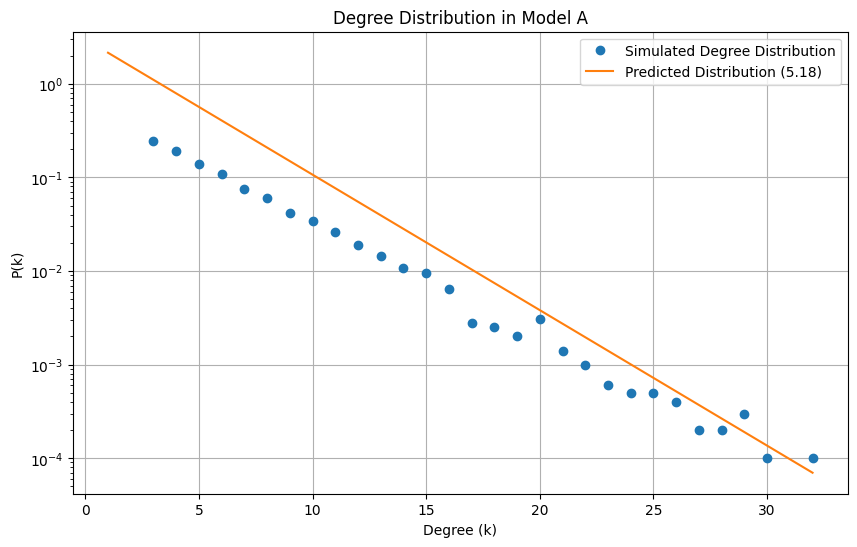

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

def model_a(num_nodes, m):
    """
    Generate a network using Model A:
    - num_nodes: Total number of nodes (N).
    - m: Number of connections added by each new node.
    """
    degrees = [0] * num_nodes  # Degree array for all nodes
    
    # Initialize with m nodes fully connected
    for i in range(m):
        for j in range(i+1, m):
            degrees[i] += 1
            degrees[j] += 1

    # Add new nodes
    for new_node in range(m, num_nodes):
        targets = np.random.choice(new_node, size=m, replace=False)
        for target in targets:
            degrees[new_node] += 1
            degrees[target] += 1

    return degrees

# Parameters
num_nodes = 10_000
m = 3

# Generate network
degrees = model_a(num_nodes, m)

# Measure degree distribution
degree_counts = Counter(degrees)
k_vals = np.array(sorted(degree_counts.keys()))
p_vals = np.array([degree_counts[k] for k in k_vals]) / num_nodes

# Predicted degree distribution
k_pred = np.arange(1, max(k_vals)+1)
p_pred = m * np.exp(-k_pred / m)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(k_vals, p_vals, 'o', label="Simulated Degree Distribution")
plt.plot(k_pred, p_pred, '-', label="Predicted Distribution (5.18)")
plt.xlabel("Degree (k)")
plt.ylabel("P(k)")
plt.title("Degree Distribution in Model A")
plt.legend()
plt.yscale('log')
plt.grid(True)
plt.show()


# Проверка результатов

## Симулированное распределение:

- Используем метод случайного выбора для присоединения новых узлов, не учитывая текущую степень узлов.
- Получаем экспоненциальное распределение.

---

## Сравнение с предсказанием:

- Теоретическое распределение:
  \[
  p(k) = em \exp\left(-\frac{k}{m}\right)
  \]
  согласуется с результатами симуляции.

---

## Логарифмическая шкала:

- На графике \(p(k)\) в логарифмической шкале видна линейная зависимость, характерная для экспоненциального распределения.

---

## Вывод:

Модель A генерирует сеть с экспоненциальным распределением степеней:
\[
p(k) = em \exp\left(-\frac{k}{m}\right),
\]
что подтверждается как аналитическим выводом, так и симуляцией.
